In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'labels.csv', 'sample_submission.csv', 'train.csv', 'train']


In [2]:
train = pd.read_csv('../input/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109237 entries, 0 to 109236
Data columns (total 2 columns):
id               109237 non-null object
attribute_ids    109237 non-null object
dtypes: object(2)
memory usage: 1.7+ MB


In [3]:
train['tags'] = train.attribute_ids.str.split(' ')
train['file'] = train.id + '.png'
train.head()

,id,attribute_ids,tags,file
0,1000483014d91860,147 616 813,"[147, 616, 813]",1000483014d91860.png
1,1000fe2e667721fe,51 616 734 813,"[51, 616, 734, 813]",1000fe2e667721fe.png
2,1001614cb89646ee,776,[776],1001614cb89646ee.png
3,10041eb49b297c08,51 671 698 813 1092,"[51, 671, 698, 813, 1092]",10041eb49b297c08.png
4,100501c227f8beea,13 404 492 903 1093,"[13, 404, 492, 903, 1093]",100501c227f8beea.png


In [4]:
'''train_flat = train.attribute_ids.str.split(' ', expand=True).stack().reset_index(drop=True, level=1).rename('id')
train_flat = pd.DataFrame({'id':train_flat.index, 'attribute_ids':train_flat.values})
train_flat['flag'] = 1
train_flat = train_flat.pivot_table(index='id', columns='attribute_ids', fill_value=0).reset_index()
train_flat.columns = [' '.join(col).strip() for col in train_flat.columns.values]
train_flat = train_flat.sort_values('id')
train_flat['img_id'] = train.id
train_flat['img_file'] = train_flat.img_id + '.png'
train_flat[['id', 'img_file', 'flag 51', 'flag 147', 'flag 616', 'flag 734', 'flag 813']].head()
cols_labels = [col for col in train_flat.columns if col.find('flag ')!=-1]
n = len(cols_labels)'''

"train_flat = train.attribute_ids.str.split(' ', expand=True).stack().reset_index(drop=True, level=1).rename('id')\ntrain_flat = pd.DataFrame({'id':train_flat.index, 'attribute_ids':train_flat.values})\ntrain_flat['flag'] = 1\ntrain_flat = train_flat.pivot_table(index='id', columns='attribute_ids', fill_value=0).reset_index()\ntrain_flat.columns = [' '.join(col).strip() for col in train_flat.columns.values]\ntrain_flat = train_flat.sort_values('id')\ntrain_flat['img_id'] = train.id\ntrain_flat['img_file'] = train_flat.img_id + '.png'\ntrain_flat[['id', 'img_file', 'flag 51', 'flag 147', 'flag 616', 'flag 734', 'flag 813']].head()\ncols_labels = [col for col in train_flat.columns if col.find('flag ')!=-1]\nn = len(cols_labels)"

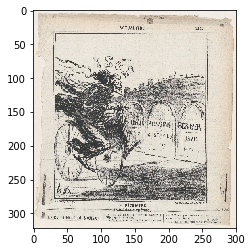

In [5]:
image = Image.open('../input/train/'+train.file[1300])
plt.imshow(image)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, train.id, test_size = 0.15, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((92851, 4), (16386, 4), (92851,), (16386,))

In [7]:
labels = pd.read_csv('../input/labels.csv')
class_list = labels.attribute_id.apply(str).unique().tolist()

In [8]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (128, 128)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(X_train, 
                                              directory='../input/train/', 
                                              x_col='file', y_col='tags', 
                                              target_size=target_size, 
                                              class_mode='categorical', classes = class_list,
                                              batch_size=batch_size)

val_gen = val_datagen.flow_from_dataframe(X_val, 
                                          directory='../input/train/', 
                                          x_col='file', y_col='tags', 
                                          target_size=target_size, class_mode='categorical', classes = class_list,
                                          batch_size=batch_size)

Using TensorFlow backend.


Found 92851 images belonging to 1103 classes.
Found 16386 images belonging to 1103 classes.


In [9]:
# from keras.applications.nasnet import NASNetLarge
from keras.applications.xception import Xception
# from keras.applications.vgg19 import VGG19

cnn_trained = Xception(input_shape=target_size + (3,), 
                       include_top=False, 
                       weights=None, 
                       # input_tensor=None, 
                       pooling=None)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = cnn_trained.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1103, activation='sigmoid')(x)

model = Model(inputs = cnn_trained.input, outputs = output)

# for layer in cnn_trained.layers:
#    layer.trainable = False

model.compile(loss='binary_crossentropy', metrics = ['cosine_proximity'], optimizer = 'adam')
# model.compile(loss='cosine_proximity', metrics = [f1], optimizer = 'adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

mc = ModelCheckpoint('imet_{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                     verbose=0, save_best_only=True, mode='auto', period=1)

es = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

log = CSVLogger('training.csv', separator=',', append=True)

cbs = [mc, es, log]

In [12]:
STEP_SIZE_TRAIN=(train_gen.n//train_gen.batch_size) + 1
STEP_SIZE_VALID=(val_gen.n//val_gen.batch_size) + 1

In [13]:
train_history = model.fit_generator(train_gen, epochs=50, 
                                    steps_per_epoch=STEP_SIZE_TRAIN, 
                                    validation_data=val_gen, validation_steps = STEP_SIZE_VALID, 
                                    callbacks = cbs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1451/1451 [==============================] - 1191s 821ms/step - loss: 0.0168 - cosine_proximity: -0.2232 - val_loss: 0.0137 - val_cosine_proximity: -0.2513
Epoch 2/50
1451/1451 [==============================] - 1166s 804ms/step - loss: 0.0130 - cosine_proximity: -0.2910 - val_loss: 0.0130 - val_cosine_proximity: -0.2923
Epoch 3/50
1451/1451 [==============================] - 1177s 811ms/step - loss: 0.0121 - cosine_proximity: -0.3437 - val_loss: 0.0125 - val_cosine_proximity: -0.3194
Epoch 4/50
1451/1451 [==============================] - 1172s 808ms/step - loss: 0.0114 - cosine_proximity: -0.3810 - val_loss: 0.0118 - val_cosine_proximity: -0.3587
Epoch 5/50
1451/1451 [==============================] - 1402s 966ms/step - loss: 0.0109 - cosine_proximity: -0.4085 - val_loss: 0.0121 - val_cosine_proximity: -0.3529
Epoch 6/50
1451/1451 [==============================] - 1164s 802ms/step - loss: 0.0105 - cosine_proximity: -0.4299 -

In [14]:
from sklearn.metrics import fbeta_score,f1_score

val_gen.reset()
preds_val = model.predict_generator(val_gen, steps=STEP_SIZE_VALID, verbose=1)
preds_val.shape

257/257 [==============================] - 84s 328ms/step


(16386, 1103)

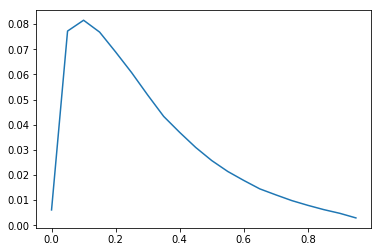

In [15]:
val_labels = val_gen.labels
acts_val = np.zeros((len(val_labels), len(class_list)))
for i in range(len(val_labels)):
    for j in val_labels[i]:
        acts_val[i,j] = 1
        
p = []
for num in np.arange(0, 1, 0.05):
    y_pred = preds_val > num
    p.append((num, f1_score(y_true=acts_val, y_pred=y_pred, average='micro')))

p = pd.DataFrame(p, columns=['threshold', 'f1'])

plt.plot(p.threshold, p.f1)

In [16]:
opt_threshold = float(p.threshold.iloc[p.f1.idxmax()])
opt_threshold

0.1

In [17]:
files = pd.DataFrame({'file':os.listdir('../input/test')})
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7443 entries, 0 to 7442
Data columns (total 1 columns):
file    7443 non-null object
dtypes: object(1)
memory usage: 58.2+ KB


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(files, 
                                            directory='../input/test/', 
                                            x_col='file', 
                                            target_size=target_size, class_mode=None, 
                                            batch_size=batch_size, shuffle = False)

Found 7443 images.


In [19]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

In [20]:
pred=model.predict_generator(test_gen, steps=STEP_SIZE_TEST+1, verbose=1)

117/117 [==============================] - 45s 383ms/step


In [21]:
pred.shape

(7443, 1103)

In [22]:
pred_bool = (pred > opt_threshold)
predictions=[]
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(" ".join(l))
filenames=[file.replace('.png','') for file in test_gen.filenames]
results=pd.DataFrame({"id":filenames,
                      "attribute_ids":predictions})
results.to_csv("submission.csv",index=False)

In [23]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7443 entries, 0 to 7442
Data columns (total 2 columns):
id               7443 non-null object
attribute_ids    7443 non-null object
dtypes: object(2)
memory usage: 116.4+ KB
